In [1]:
from os.path import join, isfile
from os import listdir
from PIL import Image
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import csv
import itertools
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier

In [2]:
import classifiers_general

In [3]:
def get_distances(keypoints):
    feats = []
    combs = [comb for comb in itertools.combinations([*range(0, len(keypoints))], 2)]
    for comb in combs:
        a = comb[0]
        b = comb[1]
        
        feats.append(distance.euclidean(keypoints[a], keypoints[b]))
    
    return feats

## From landmark to all distances for syndromic files

## From landmark to all distances for control files

In [4]:
def get_important_features(syn_name, data_dir, data_combination, nr_feats): 

    if data_combination == 9: # facereader landmarks
        method = "facereader-landmarks-distances"
        syn_csv = data_dir+"\\representations\{}-patients-{}.csv".format(syn_name, method)
        ID_csv  = data_dir+"\\representations\ID-controls-{}.csv".format(method)
        data_fr, labels_fr = classifiers_general.read_rep(syn_name, syn_csv, ID_csv, data_dir)

        data, labels  = [], []
        for index, data_i in enumerate(data_fr):
            if not all(v == 0 for v in data_i):
                data.append(data_i) 
                labels.append(labels_fr[index])
                
        forest = RandomForestClassifier(n_estimators=10,random_state=0) # 10 has been found with best aroc scores
        forest.fit(data, labels)
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
        indices = np.argsort(importances)[::-1]
        important_indices = indices[0:nr_feats] 
        
        print(sum(importances[important_indices]))

        data2 = []
        for row in data:
            data2.append(np.array(row)[important_indices])                                
        data = data2
                
    return np.array(data), np.array(labels),important_indices

def get_keypoints_from_indices(indices):

    combs = [comb for comb in itertools.combinations([*range(0, 510)], 2)]
    keypoints = []
    for index, comb in enumerate(combs):
        if index in indices:
                      
            a = comb[0]
            b = comb[1]
            keypoints.append([a, b])
        
    return keypoints

In [5]:
def fr_plot(patient, GENERAL_DIR):
    face_x = []
    face_y = []
    face_z = []

    
    file = GENERAL_DIR + "\\features_facereader_landmarks_patient_groups.csv"
    print(file)
    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if patient in row[0]:
                print(row[0])
                indexed_keypoints = []
                i = 1
                while i < len(row[1:]):
                    indexed_keypoints.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    face_x.append(float(row[i]))
                    face_y.append(float(row[i+1]))
                    face_z.append(float(row[i+2]))
                    i+=3    
                break
    face_x = np.array(face_x)
    face_y = np.array(face_y)
    face_z = np.array(face_z)
    return face_x, face_y, face_z, indexed_keypoints

In [6]:
def get_patient_keypoints(important_keypoints, indexed_keypoints):
    
    keypoints3D = []
        
    for [a, b] in important_keypoints:
        
        keypoints3D.append([indexed_keypoints[a], indexed_keypoints[b]])
        
        
    return keypoints3D

In [7]:
syn_name = 'ANKRD11'
patient = 'ANKRD11_1.jpg'
GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien"

x, y, z, indexed_keypoints = fr_plot(patient, GENERAL_DIR)

data_dir = GENERAL_DIR + "\\{}".format(syn_name) 
nr_feats = 10

_, _, indices = get_important_features(syn_name, data_dir, 9, nr_feats)
important_keypoints = get_keypoints_from_indices(indices)
keypoints_3d = get_patient_keypoints(important_keypoints, indexed_keypoints)



H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\features_facereader_landmarks_patient_groups.csv
ANKRD11_1.jpg
0.7616557016339387


<IPython.core.display.Javascript object>


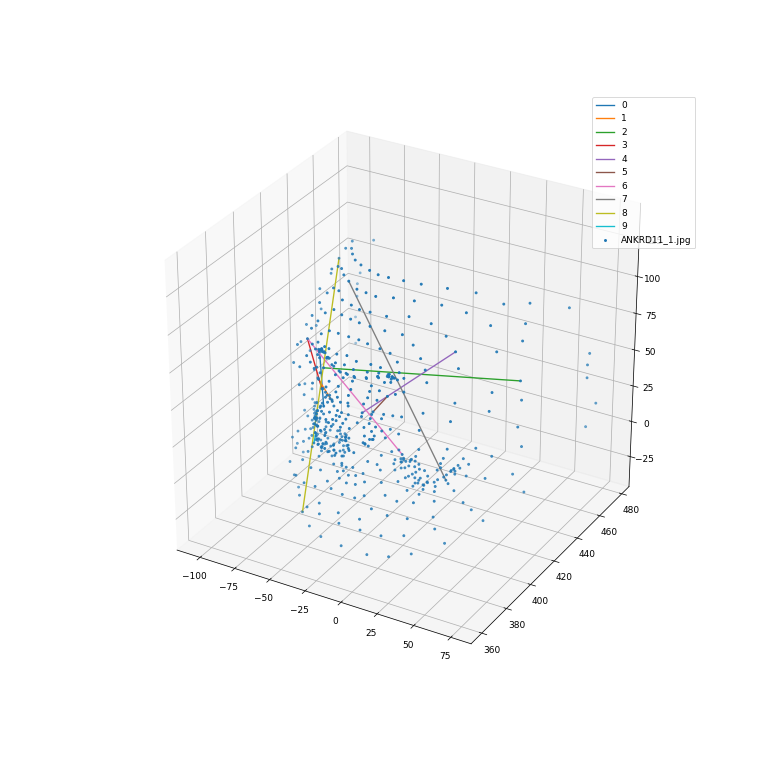

In [8]:
%matplotlib notebook
import plotly.graph_objects as go
from scipy.spatial import Delaunay

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.scatter(x, z, y, s = 5, label=patient)

item = 1
for [[a, b, c], [x, y, z]] in keypoints_3d:
    ax.plot([a,x], [c, z], [b,y], label = item)
    item += 1

ax.legend()

plt.show()


# pts3d = np.vstack((x, y, z)).T
# pts2d = pts3d[:, :2]
# tri =   Delaunay(pts2d)
# i, j, k = tri.simplices.T  #tri.simplices (faces) is an array of integers of shape (no_triangles, 3)

# fig = go.Figure(go.Mesh3d(x=x, y=y, z=z,
#                           i=i, j=j, k=k,#intensity=z, 
#                           #colorscale='matter_r', 
#                           flatshading=True))
# fig.show()

